In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#import pandas_datareader.data as web
#from ta import add_all_ta_features
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')


In [2]:
data = pd.read_csv("datasets/heart.csv")
data.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


<AxesSubplot:xlabel='target', ylabel='count'>

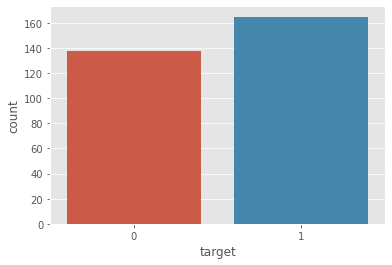

In [3]:
sns.countplot(x = 'target', data = data)

Building & Running the model

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [5]:
def report_results(model,y_pred,history):
    print(f"Accuracy/Score: {accuracy_score(y_test, y_pred)}")
    print(f"Precision = {precision_score(y_test, y_pred)}\n")
    #print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}")
    print("Classification Report:\n")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:\n")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    roc(model,y_pred)
    print("Acuuracy & Loss:\n")
    accuracy_loss(history)
    plt.show()
    print("ROC:\n")

In [6]:
def roc(model,y_pred):
    logit_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"Ann_model(area = {round(logit_roc_auc,2)})")
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

In [7]:
def accuracy_loss(history):
    #  "Accuracy Plot"
    fig, ax= plt.subplots(1,2,figsize=(13,5))
    ax[0].set_title("Model Accuracy")
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'validation'], loc='upper left')

    # "Loss Plot"
    ax[1].set_title('Model Loss')
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'validation'], loc='upper left')
    plt.show()

In [8]:
def create_model():
	# create model
    # Init the model
    clf_model = tf.keras.models.Sequential()
    # First layer inputs
    clf_model.add(tf.keras.Input(shape=(X_train.shape[1],)))
    # hidden layers number 1
    clf_model.add(tf.keras.layers.BatchNormalization())
    clf_model.add(tf.keras.layers.Dense(128, activation='relu'))
    clf_model.add(tf.keras.layers.Dropout(0.2))          
    # hidden layers number 2
    clf_model.add(tf.keras.layers.BatchNormalization())  
    clf_model.add(tf.keras.layers.Dense(64 , activation='relu'))
    clf_model.add(tf.keras.layers.Dropout(0.2))
    # hidden layers number 3
    clf_model.add(tf.keras.layers.BatchNormalization())
    clf_model.add(tf.keras.layers.Dense(16 , activation='relu'))
    # Last layer
    clf_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # print summary to undertstand your neural network flow
    clf_model.summary()

    return clf_model

In [9]:
X, y = data.drop('target',axis=1), data['target']

In [10]:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=77)

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
seed = 7
tf.random.set_seed(seed)
# create model
model = KerasClassifier(model=create_model, 
                        loss="binary_crossentropy", 
                        optimizer="Adam", 
                        metrics="accuracy",
                        verbose=1)
# define the grid search parameters
learn_rate = [0.001, 0.005]
batch_size = [30,40,50]
epochs = [50,100,150]
# 0.001, 40, 100

In [28]:
param_grid = dict(optimizer__learning_rate=learn_rate, batch_size=batch_size, epochs= epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(X, y)

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_129 (Ba  (None, 13)               52        
 tchNormalization)                                               
                                                                 
 dense_172 (Dense)           (None, 128)               1792      
                                                                 
 dropout_86 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_130 (Ba  (None, 128)              512       
 tchNormalization)                                               
                                                                 
 dense_173 (Dense)           (None, 64)                8256      
                                                                 
 dropout_87 (Dropout)        (None, 64)              

In [29]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.828383 using {'batch_size': 50, 'epochs': 150, 'optimizer__learning_rate': 0.001}


Implementing best params

In [30]:
Optimizer = tf.keras.optimizers.Adam(learning_rate=grid_result.best_params_['optimizer__learning_rate'])
model = create_model()
model.compile(Optimizer, 
              loss='binary_crossentropy', 
              metrics=["accuracy"])
epochs_hist = model.fit(X_train,
                        y_train,
                        validation_data=(X_test , y_test),
                        batch_size=grid_result.best_params_['batch_size'], 
                        epochs=grid_result.best_params_['ephocs'])

Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_294 (Ba  (None, 13)               52        
 tchNormalization)                                               
                                                                 
 dense_392 (Dense)           (None, 128)               1792      
                                                                 
 dropout_196 (Dropout)       (None, 128)               0         
                                                                 
 batch_normalization_295 (Ba  (None, 128)              512       
 tchNormalization)                                               
                                                                 
 dense_393 (Dense)           (None, 64)                8256      
                                                                 
 dropout_197 (Dropout)       (None, 64)              

2/2 [==============================] - 0s 4ms/step
Accuracy/Score: 0.9016393442622951
Precision = 0.8888888888888888

Classification Report:

              precision    recall  f1-score   support

           0     0.9200    0.8519    0.8846        27
           1     0.8889    0.9412    0.9143        34

    accuracy                         0.9016        61
   macro avg     0.9044    0.8965    0.8995        61
weighted avg     0.9027    0.9016    0.9012        61

Confusion Matrix:

2/2 [==============================] - 0s 4ms/step


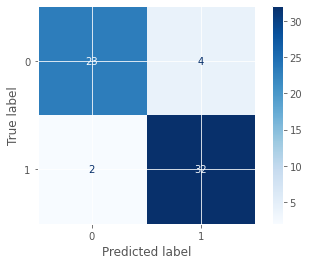

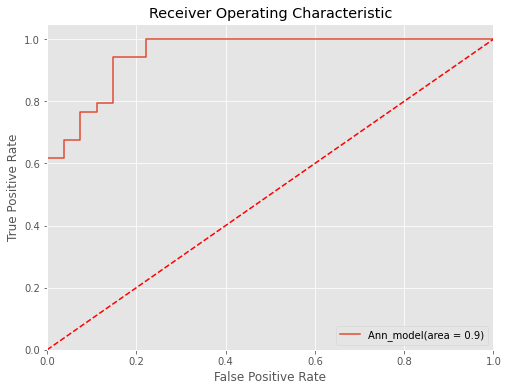

Acuuracy & Loss:



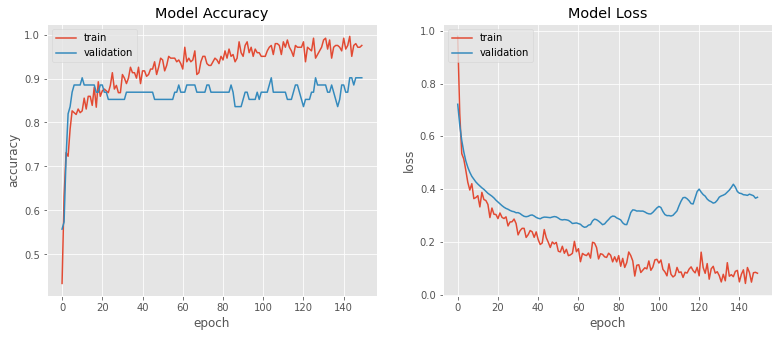

ROC:



In [31]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
report_results(model ,y_pred, epochs_hist)